In [1]:
import string
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.stem import PorterStemmer
from tensorflow import keras
import tensorflow_text
import tensorflow as tf
import tensorflow_hub as hub
import re
tf.get_logger().setLevel('ERROR')

In [2]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')
val = pd.read_csv('val.csv')

In [3]:
# this function receives comments and returns clean word-list
def clean_doc(text_record):
    # split tokens by white space
    tokens = text_record.split()
    # remove punctuation from each string
    table = str.maketrans({key: None for key in string.punctuation})
    tokens = [token.translate(table) for token in tokens]
    # remove tokens that are not alphabetic
    tokens = [token for token in tokens if token.isalpha()]
    # convert letters to lower case
    
    tokens = [token.lower() for token in tokens]
    #stem tokens
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(token.lower()) for token in tokens]
    # tokens = stemmer.stem(tokens.lower())
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    
    tokens = [token for token in tokens if token not in stop_words]
    # remove short words (one letter)
    tokens = [token for token in tokens if len(token) > 1]
    # lemmatization
    lem = WordNetLemmatizer()
    tokens = [lem.lemmatize(token,'v') for token in tokens]
    sentence = ' '.join(tokens)
    return sentence

In [4]:
class_names = ['income', 'housing', 'insurance', 'alcohol', 'substance', 'tobacco', 'disability']
train_text_clean = [clean_doc(comment) for comment in train.RESULT_TVAL]
val_text_clean = [clean_doc(comment) for comment in val.RESULT_TVAL]
test_text_clean = [clean_doc(comment) for comment in test.RESULT_TVAL]

Y_train = train[class_names]
Y_val = val[class_names]
Y_test = test[class_names]

## Evaluate BERT-based Classifier

In [5]:
classifier_model = keras.models.load_model('fine_tuning_bert_bilstm.keras', custom_objects={'KerasLayer':hub.KerasLayer})

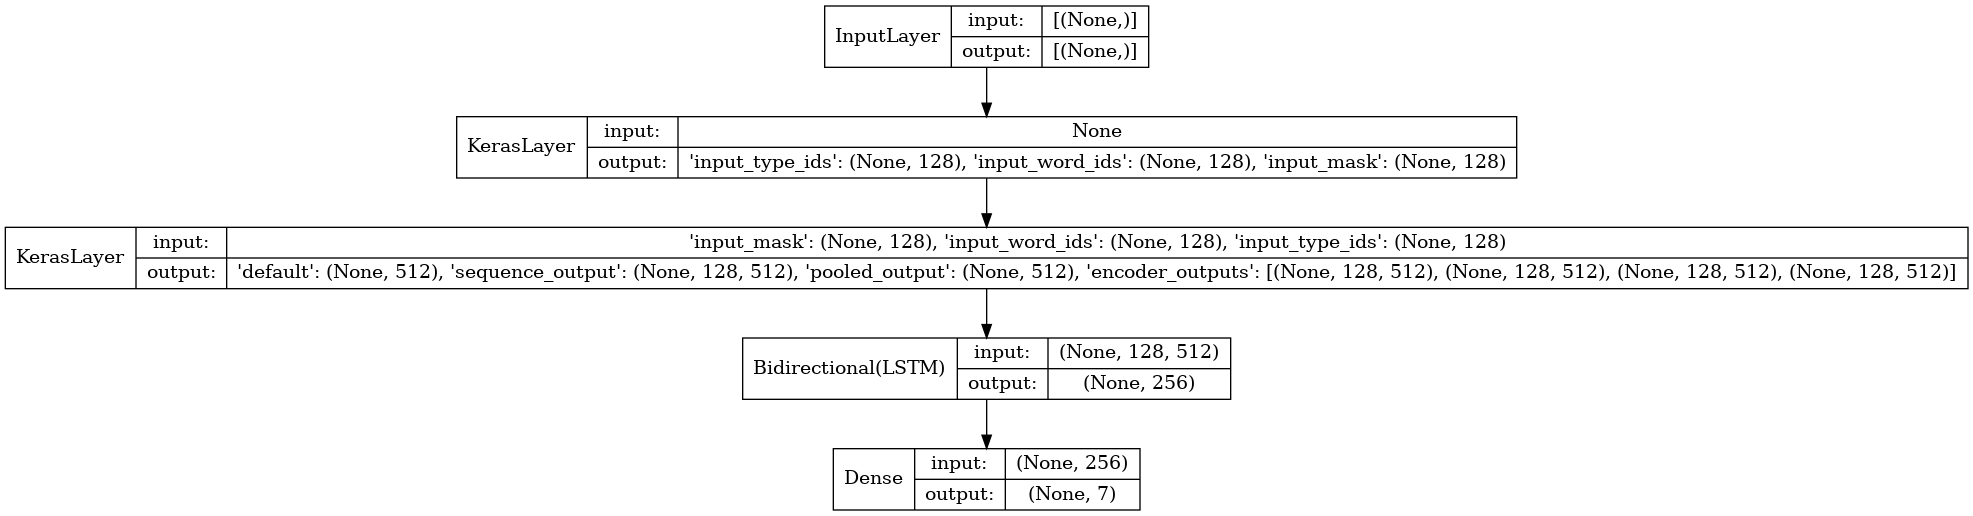

In [31]:
tf.keras.utils.plot_model(classifier_model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [6]:
Y_pred = classifier_model.predict(pd.Series(test_text_clean), verbose=1)

19/19 [==============================] - 27s 1s/step


In [10]:
from sklearn.metrics import f1_score, roc_auc_score, classification_report, average_precision_score, precision_recall_curve, recall_score

print(f'Average precesion score : {average_precision_score(Y_test.to_numpy(), Y_pred)}')
print(f'AUC : {roc_auc_score(Y_test.to_numpy(), Y_pred)}') # AUC score
print(f'F1 score {f1_score(Y_test.to_numpy(), (Y_pred > 0.5), average="micro")}')
# recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
print(classification_report(Y_test.to_numpy(), (Y_pred > 0.5))) 


Average precesion score : 0.8731907864443159
AUC : 0.9767461482636266
F1 score 0.8366666666666667
              precision    recall  f1-score   support

           0       0.75      0.71      0.73        59
           1       0.93      0.90      0.92        31
           2       0.85      0.85      0.85        34
           3       0.90      0.87      0.88        53
           4       0.86      0.69      0.77        62
           5       0.97      0.95      0.96        39
           6       0.74      0.93      0.83        28

   micro avg       0.85      0.82      0.84       306
   macro avg       0.86      0.84      0.85       306
weighted avg       0.86      0.82      0.84       306
 samples avg       0.38      0.36      0.37       306



/home/ubuntu/.conda/envs/pyml36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.conda/envs/pyml36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


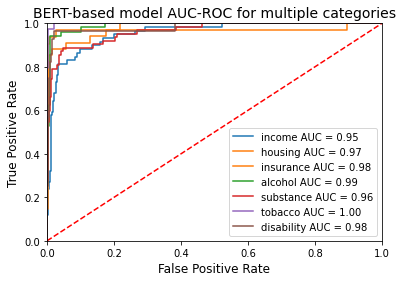

In [27]:
from sklearn.metrics import roc_curve, auc
colors = ['tab:blue', 'tab:orange', 'tab:orange', 
          'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
plt.figure(0).clf() 
for i, c in enumerate(class_names):
  fpr, tpr, threshold = roc_curve(Y_test[c], Y_pred[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, colors[i], label = f'{c} AUC = {roc_auc:.2f}')


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.title('BERT-based model AUC-ROC for multiple categories', fontsize=14)
plt.savefig('BERT_roc.png')

## Token Matching

In [12]:
import re
import pickle
import nltk

def clean(x):
  x = x.lower()
  x = re.sub(r'[^\w\s]', '', x)
  x = re.sub(r'\d+', '', x)
  x = re.sub(r'\b\w\b', '', x)
  x = re.sub(r'\s+', ' ', x)
  return x.split()

with open('model/bigram.pkl','rb') as f:
  bigram = pickle.load(f)
print('bigram loaded')

bigram loaded


In [13]:
SDOH_dict = {
  'income' : [
    'veteran','unemployed','selfemployed','losing_job','lost_job','jail','welfare','finances','financial_concerns','financial_reasons','concern_decompensation','financially','financial_strain','released_prison','prison','probation','criminal','trespassing','payments','cost','lack_resources',
  ],
  'housing' : [
    'streets','transitional_housing','flooded','homelessness','homeless','lived_homeless','homeless_shelter','friends_house','infested','black_mold','landlord','motel','pay_rent','mothers_house','shelter',
  ],
  'insurance' : [
    'insurance_reasons','expensive','medicaid','cheaper','copay','insurance_issues','lost_insurance','lack_insurance','uninsured',
  ],
  'alcohol' : [
    'abuse','hard_liquor','addiction','alcohol','alcoholic_beverage','alcoholism','beers','couple_beers','beer','binge_drinking','blackout','binge','drinking_heavily','drinking_beer','alcoholic_drink','drinker','beer_pint','dependence','gin','hangover','alcholic_drink','drank_vodka','alcohol_intoxication','bottle_wine','intoxication','glass_wine','drank_wine','liquor','margarita','bourbon','rum','scotch','sober','pack_beer','drank_beers','tequila','vodka','whiskey','wine', 
  ],
  'substance' : [
    'weed','pot','ecstasy','cocaine','recreational_drug','cocaine_heroin','abusecocaine','cocain','marijuana_cocaine','crack_cocaine','polysubstance_abuse','drug_abuse','drug','heroin','abusing','smoked_crack','smoker','crack','craving','marijuana','intentional_overdose','drug_overdose','narcotic','opioid','overdose',
  ],
  'smoke' : [
    'opioid_abuse','abuse_tobacco','cigar','cigarette','still_smokes','cig','smoking_cigarettes','abstain_tobacco','outside_smoke','smokes_cigarettes','nicotine_abuse','hookah','nicotine','admits_smoking','smoke','tobacco','vape',
  ],
  'disability' : [
    'disabled','disability',
  ]
}

In [14]:
stop_words = set(stopwords.words('english'))
Y_pred1 = []
classes = list(SDOH_dict.keys())
notes = test['RESULT_TVAL'].apply(lambda note: [sentence for sentence in note.split('.') if sentence != ''])
for note in notes:
  tokens = set()
  res = [0, 0, 0, 0, 0, 0, 0]
  for sentence in note:
    cleaned = ' '.join([w for w in clean(sentence) if w not in stop_words])
    if cleaned != '':
      tokens.update(bigram[nltk.word_tokenize(cleaned)])
      tokens.update(nltk.word_tokenize(cleaned))
  for t in tokens:
    for i in range(len(classes)):
      if t in SDOH_dict[classes[i]]:
        res[i] = 1
        continue
  Y_pred1.append(res)

In [15]:
print(f'Average precesion score : {average_precision_score(Y_test.to_numpy(), Y_pred1)}')
print(f'AUC : {roc_auc_score(Y_test.to_numpy(), Y_pred1)}') # AUC score
print(f'F1 score {f1_score(Y_test.to_numpy(), Y_pred1, average="macro")}')
# recall of the positive class is also known as “sensitivity”
# recall of the negative class is “specificity”
print(classification_report(Y_test.to_numpy(), Y_pred1))

Average precesion score : 0.6191696882449176
AUC : 0.9260073672513903
F1 score 0.7647258131223609
              precision    recall  f1-score   support

           0       0.57      0.85      0.68        59
           1       0.83      0.94      0.88        31
           2       0.68      0.79      0.73        34
           3       0.49      0.87      0.63        53
           4       0.52      0.94      0.67        62
           5       0.90      0.90      0.90        39
           6       0.76      1.00      0.86        28

   micro avg       0.62      0.89      0.73       306
   macro avg       0.68      0.90      0.76       306
weighted avg       0.64      0.89      0.74       306
 samples avg       0.39      0.40      0.39       306



/home/ubuntu/.conda/envs/pyml36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.conda/envs/pyml36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


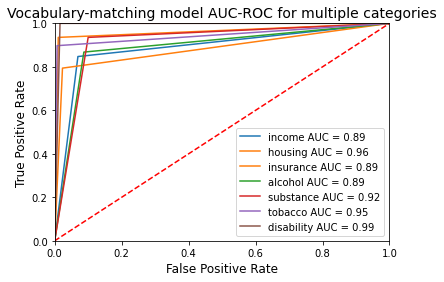

In [28]:
colors = ['tab:blue', 'tab:orange', 'tab:orange', 
          'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
plt.figure(0).clf() 
for i, c in enumerate(class_names):
  fpr, tpr, threshold = roc_curve(Y_test[c], np.array(Y_pred1)[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, colors[i], label = f'{c} AUC = {roc_auc:.2f}')


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.title('Vocabulary-matching model AUC-ROC for multiple categories', fontsize=14)
plt.savefig('Matching_roc.png')

## Bi-LSTM with GloVe

In [17]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences

In [18]:
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_text_clean)
train_encoded = tokenizer.texts_to_sequences(train_text_clean)
val_encoded = tokenizer.texts_to_sequences(val_text_clean)
test_encoded = tokenizer.texts_to_sequences(test_text_clean)

# vocabulary size 
print('The vocabulary size is {}.'.format(len(tokenizer.word_index)))

#length of comment 
print("length of encoded comments-->",len(train_encoded))
print(train_encoded[0])
print("length of encoded comments-->",len(train_encoded))
print(train_encoded[0])

The vocabulary size is 10454.
length of encoded comments--> 4687
[126, 86, 34, 1, 743, 2008, 90, 11, 100, 71, 914, 90, 11, 45, 51, 1, 1164, 51, 34, 24, 2908]
length of encoded comments--> 4687
[126, 86, 34, 1, 743, 2008, 90, 11, 100, 71, 914, 90, 11, 45, 51, 1, 1164, 51, 34, 24, 2908]


In [19]:
# get equal length vectors for all the comments 
maxlen = 700

# load the whole embedding into memory
def create_embeddings_index(filename):
    embeddings_index = dict()
    f = open(filename, encoding = 'utf-8')
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()
    print('Loaded %s word vectors.' % len(embeddings_index.keys()))
    return embeddings_index
  
# create a weight matrix for words in training docs (look up word vectors in embeddings_index)
def create_embeddings_matrix(tokenizer, embeddings_index):
   # print("Word index",tokenizer.word_index)
    vocab_size = len(tokenizer.word_index) + 1
    embeddings_matrix = np.zeros((vocab_size, 100))
    for word, i in tokenizer.word_index.items():
        embeddings_vector = embeddings_index.get(word)
        if embeddings_vector is not None:
            embeddings_matrix[i] = embeddings_vector
    return embeddings_matrix

In [20]:
# GloVe model
# load the whole embedding into memory
embeddings_index_glove = create_embeddings_index('glove.6B.100d.txt')
embeddings_matrix_glove = create_embeddings_matrix(tokenizer, embeddings_index_glove)
print(embeddings_matrix_glove)

Loaded 400000 word vectors.
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.16169     0.52358001 -0.20175999 ... -0.46375     0.21377
  -0.26859   ]
 [-0.19329     0.16779999  0.12382    ... -0.61945999  0.16678999
  -0.64516997]
 ...
 [ 0.35633999 -0.20063999 -0.23401    ... -0.66755003 -0.010199
   0.20243999]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [21]:
X_train = pad_sequences(train_encoded, maxlen = maxlen, padding = 'post')
X_val = pad_sequences(val_encoded, maxlen = maxlen, padding = 'post')
X_test = pad_sequences(test_encoded, maxlen = maxlen, padding = 'post')

In [22]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Flatten, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping 
from keras.layers.convolutional import Conv1D, MaxPooling1D

# define the model
vocab_size = len(tokenizer.word_index) + 1

model_glove = Sequential()
model_glove.add(Embedding(vocab_size, 100, weights = [embeddings_matrix_glove], input_length = maxlen, trainable = False))
model_glove.add(Bidirectional(LSTM(128, return_sequences=True)))
model_glove.add(GlobalMaxPool1D())
model_glove.add(Dropout(0.25))
model_glove.add(Dense(len(class_names), activation="sigmoid"))

In [59]:
from tensorflow.keras import optimizers

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="biLSTM.keras",
        save_best_only=True,
        monitor="val_loss")
]

model_glove.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.metrics.BinaryAccuracy(), tf.metrics.AUC()])

history = model_glove.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=256, epochs=50)

Epoch 1/50
19/19 [==============================] - 78s 4s/step - loss: 0.2512 - binary_accuracy: 0.9284 - auc_1: 0.6202 - val_loss: 0.2635 - val_binary_accuracy: 0.9198 - val_auc_1: 0.6927
Epoch 2/50
19/19 [==============================] - 73s 4s/step - loss: 0.2358 - binary_accuracy: 0.9287 - auc_1: 0.7234 - val_loss: 0.2446 - val_binary_accuracy: 0.9198 - val_auc_1: 0.8011
Epoch 3/50
19/19 [==============================] - 71s 4s/step - loss: 0.2156 - binary_accuracy: 0.9297 - auc_1: 0.8072 - val_loss: 0.2211 - val_binary_accuracy: 0.9225 - val_auc_1: 0.8440
Epoch 4/50
19/19 [==============================] - 68s 4s/step - loss: 0.1984 - binary_accuracy: 0.9323 - auc_1: 0.8491 - val_loss: 0.2072 - val_binary_accuracy: 0.9235 - val_auc_1: 0.8686
Epoch 5/50
19/19 [==============================] - 64s 3s/step - loss: 0.1838 - binary_accuracy: 0.9337 - auc_1: 0.8831 - val_loss: 0.1941 - val_binary_accuracy: 0.9246 - val_auc_1: 0.8877
Epoch 6/50
19/19 [==============================] 

In [23]:
# model_glove.save('biLSTM.keras')
model_glove = keras.models.load_model('biLSTM.keras')

In [24]:
Y_pred2 = model_glove.predict(X_test)

In [25]:
print(f'Average precesion score : {average_precision_score(Y_test.to_numpy(), Y_pred2, average="macro")}')
print(f'AUC : {roc_auc_score(Y_test.to_numpy(), Y_pred2)}') # AUC score
print(f'F1 score {f1_score(Y_test.to_numpy(), (Y_pred2 > 0.5), average="macro")}')
# recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
print(classification_report(Y_test.to_numpy(), (Y_pred2 > 0.5))) 

Average precesion score : 0.643025533777098
AUC : 0.8994159890216997
F1 score 0.603948400619
              precision    recall  f1-score   support

           0       0.49      0.36      0.41        59
           1       0.95      0.68      0.79        31
           2       0.52      0.38      0.44        34
           3       0.91      0.60      0.73        53
           4       0.73      0.60      0.65        62
           5       0.96      0.64      0.77        39
           6       0.48      0.39      0.43        28

   micro avg       0.71      0.52      0.60       306
   macro avg       0.72      0.52      0.60       306
weighted avg       0.72      0.52      0.60       306
 samples avg       0.25      0.23      0.23       306



/home/ubuntu/.conda/envs/pyml36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ubuntu/.conda/envs/pyml36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


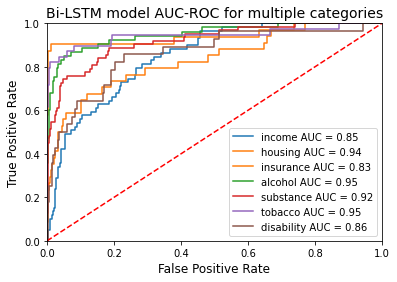

In [29]:
plt.figure(0).clf() 
for i, c in enumerate(class_names):
  fpr, tpr, threshold = roc_curve(Y_test[c], Y_pred2[:, i])
  roc_auc = auc(fpr, tpr)
  plt.plot(fpr, tpr, colors[i], label = f'{c} AUC = {roc_auc:.2f}')


plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.title('Bi-LSTM model AUC-ROC for multiple categories', fontsize=14)
plt.savefig('BiLSTM_roc.png')